<a href="https://colab.research.google.com/github/JumpNShootMan/TP_MachineLearning/blob/master/TP_ML_KerasTensorflow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [ ]:
import cv2
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/JumpNShootMan/TP_MachineLearning/master/datos_banco.csv', encoding='latin-1')

data.head(10)

,idPrestamo,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,person_gender,credit_history_marital_status,var_max_sbs_qual_12m,person_degree_type_desc,default_request_term,default_request_amount
0,LIBDISP9832897855,1,252.39,9.0,"1,200",6,289.11,1140.125000,MALE,C,NORMAL,Secundaria,1,0
1,LIBDISP9021501745,1,244.57,50.0,"2,200",12,696.15,1061.375000,FEMALE,S,NORMAL,Secundaria,0,0
2,LIBDISP4057314971,0,491.5,64.0,"1,000",3,84.99,2082.196667,FEMALE,S,NORMAL,Secundaria,0,0
3,LIBDISP8375185888,0,848.65,77.0,"1,500",6,221.53,3422.423333,MALE,S,NORMAL,Universitaria,0,0
4,LIBDISP9694463037,0,470.52,82.0,"1,000",3,91.34,1882.090000,FEMALE,S,NORMAL,Universitaria,1,0
5,LIBDISP0492929616,0,490.77,79.0,"1,500",6,221.53,2448.016667,MALE,S,NORMAL,Carrera TÃÂ©cnica,1,0
6,LIBDISP6813272232,0,428.57,71.0,"4,000",12,"1,109.56",1803.923333,FEMALE,S,NORMAL,Universitaria,0,0
7,LIBDISP8862427268,1,647.87,4.0,"1,200",6,289.11,2660.630000,MALE,S,NORMAL,Secundaria,1,0
8,LIBDISP7167831610,0,694.23,NaN,900,6,149.79,2912.158333,FEMALE,C,CPP,Universitaria,1,0
9,LIBDISP3835927929,1,209.48,77.0,"1,000",6,152.32,2498.043333,MALE,S,NORMAL,Secundaria,1,0


In [ ]:
data.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity             object
var_employment_time_in_months    float64
approved_amount                   object
approved_term                      int64
approved_interest_amount          object
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

# Pre-procesamiento

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.engine.saving import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Eliminación de atributos innecesarios para la tarea de clasificación. 'idPrestamo' por ser un indice y 'default_request_amount' por solo tener data de uno de sus valores '0'.

In [ ]:
del data["idPrestamo"]
del data["default_request_amount"]

Union de las instancias con valor 'Carrera TÃÂ©cnica' y 'Carrera TÌÄå©cnica' en un solo valor 'Carrera Tecnica'.

In [ ]:
for i in range(len(data['person_degree_type_desc'])):
  if data['person_degree_type_desc'][i] == "Carrera TÃÂ©cnica" or data['person_degree_type_desc'][i] == "Carrera TÌÄå©cnica":
    data['person_degree_type_desc'][i] = "Carrera Tecnica"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


OneHotEnconding para los atributos cualitativos.

In [ ]:
def oneHotEncoding(feature):
  onehot_encoded = pd.get_dummies(data[feature], prefix=feature)
  del data[feature]
  return data.join(onehot_encoded)

In [ ]:
data = oneHotEncoding('person_gender')
data = oneHotEncoding('credit_history_marital_status')
data = oneHotEncoding('var_max_sbs_qual_12m')
data = oneHotEncoding('person_degree_type_desc')

Transformación de los valores tipo object a valores numéricos.

In [ ]:
for i in data:
  for j in range(len(data[i])):
    if type(data[i][j]) == str:
      data[i][j] = data[i][j].replace(',', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
for i in data:
  if data[i].dtype == object:
    data[i] = pd.to_numeric(data[i])

Remplazo de valores faltantes utilizando SimpleImputer.

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data.var_employment_time_in_months = imputer.fit_transform(data['var_employment_time_in_months'].values.reshape(-1,1))

Normalización MinMax para los valores que originalmente eran cuantitativos, excepto 'approved_term' porque son meses.

In [ ]:
def standardization(feature):
  scaler = MinMaxScaler()
  return scaler.fit_transform(data[feature].values.reshape(-1,1))

In [ ]:
data['monthly_debt_capacity'] = standardization('monthly_debt_capacity')
data['var_employment_time_in_months'] = standardization('var_employment_time_in_months')
data['approved_amount'] = standardization('approved_amount')
data['approved_interest_amount'] = standardization('approved_interest_amount')
data['var_net_income'] = standardization('var_net_income')

In [ ]:
data.head(10)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,person_gender_FEMALE,person_gender_MALE,credit_history_marital_status_C,credit_history_marital_status_D,credit_history_marital_status_S,credit_history_marital_status_V,var_max_sbs_qual_12m_CPP,var_max_sbs_qual_12m_DEFICIENTE,var_max_sbs_qual_12m_DUDOSO,var_max_sbs_qual_12m_NORMAL,var_max_sbs_qual_12m_PERDIDA,person_degree_type_desc_Carrera Tecnica,person_degree_type_desc_Postgrado,person_degree_type_desc_Primaria,person_degree_type_desc_Secundaria,person_degree_type_desc_Universitaria
0,1,0.055545,0.113636,0.059829,6,0.116370,0.039883,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0.054488,0.579545,0.145299,12,0.294249,0.037128,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0.087848,0.738636,0.042735,3,0.027169,0.072837,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0.136099,0.886364,0.085470,6,0.086837,0.119720,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,0.085014,0.943182,0.042735,3,0.029944,0.065837,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0.087750,0.909091,0.085470,6,0.086837,0.085634,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0.079347,0.818182,0.299145,12,0.474912,0.063103,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
7,1,0.108974,0.056818,0.059829,6,0.116370,0.093071,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
8,0,0.115237,0.397495,0.034188,6,0.055487,0.101870,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
9,1,0.049748,0.886364,0.042735,6,0.056592,0.087384,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


# TensorFlow Classifier

### Especificar tamaño de columnas que se van a evaluar

In [ ]:
inputDim = 15

In [ ]:
X = data.iloc[:,1:]
y = data.target

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
def embedded(x_,y_):
    rf = RandomForestRegressor()
    rf.fit(x_, y_)
    scores_ = rf.feature_importances_
    columnsEmbeding = []
    tupla = []
    for i in range(len(scores_)):
        tupla.append( (x_.columns[i], scores_[i]) )
    tupla.sort(key=lambda tup: tup[1])
    for i in range(inputDim):
        columnsEmbeding.append(tupla[i][0])
    return columnsEmbeding

In [ ]:
columns = embedded(x_train,y_train)
columns

['credit_history_marital_status_V',
 'var_max_sbs_qual_12m_DUDOSO',
 'var_max_sbs_qual_12m_PERDIDA',
 'credit_history_marital_status_D',
 'person_degree_type_desc_Primaria',
 'var_max_sbs_qual_12m_DEFICIENTE',
 'person_degree_type_desc_Postgrado',
 'var_max_sbs_qual_12m_CPP',
 'var_max_sbs_qual_12m_NORMAL',
 'credit_history_marital_status_C',
 'credit_history_marital_status_S',
 'approved_term',
 'person_gender_MALE',
 'person_gender_FEMALE',
 'person_degree_type_desc_Universitaria']

In [ ]:
from sklearn.preprocessing import normalize
x_traints = x_train[columns].to_numpy()
x_testts = x_test[columns].to_numpy()
x_traints = normalize(x_traints)
x_testts = normalize(x_testts)
y_traints = y_train.to_numpy()
y_testts = y_test.to_numpy()

In [ ]:
len(x_traints)
x_testts.shape

(344, 15)

In [135]:
model = Sequential([Dense(5, input_dim=15, activation= keras.activations.selu),
                    Dense(2,activation= keras.activations.sigmoid),
                    Dense(3,activation= keras.activations.softmax),
                    Dense(1, activation= keras.activations.relu)])
#opt = keras.optimizers.Adam()
opt = keras.optimizers.SGD()
#opt = keras.optimizers.Adagrad()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [136]:
hist = model.fit(x_traints, y_traints, epochs=30, batch_size=100, verbose=2)

Epoch 1/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 2/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 3/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 4/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 5/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 6/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 7/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 8/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 9/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 10/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 11/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 12/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 13/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 14/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 15/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 16/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 17/30
14/14 - 0s - loss: 4.6892 - accuracy: 0.6960
Epoch 18/30
14/14 - 0s - loss: 4.6892 - 

In [137]:
model.evaluate(x_testts, y_testts)

11/11 [==============================] - 0s 2ms/step - loss: 4.0356 - accuracy: 0.7384


[4.03559684753418, 0.7383720874786377]

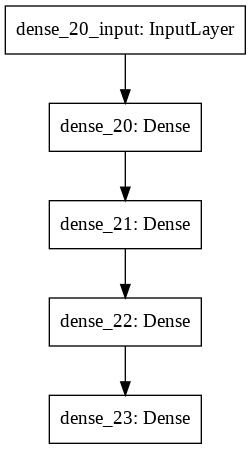

In [138]:
keras.utils.plot_model(model)

In [139]:
print(hist.history)

{'loss': [4.689184188842773, 4.689183712005615, 4.689184188842773, 4.689184188842773, 4.689184188842773, 4.689183712005615, 4.689184188842773, 4.689184188842773, 4.689183712005615, 4.689184665679932, 4.689184188842773, 4.689183712005615, 4.689184665679932, 4.689184188842773, 4.689184665679932, 4.689184188842773, 4.689184665679932, 4.689183712005615, 4.689183712005615, 4.689184188842773, 4.689184188842773, 4.689184188842773, 4.689184665679932, 4.689183712005615, 4.689183712005615, 4.689184188842773, 4.689183712005615, 4.689184188842773, 4.689184665679932, 4.689184188842773], 'accuracy': [0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959999799728394, 0.6959

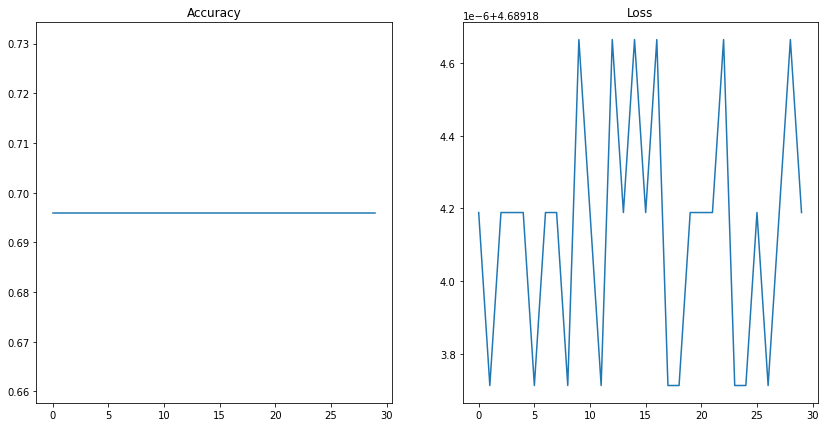

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=[14,7])
ax= plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title('Accuracy')
ax= plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title('Loss')
plt.show()

In [ ]:
model.save('bancos_tfmodel.h5')